In [1]:
!pip install -q efficientnet 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 972.9 kB/s eta 0:00:00


Mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp '/content/drive/MyDrive/Colab Notebooks/kaggle.json' ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k 

 95% 1.54G/1.62G [00:07<00:00, 208MB/s]
User cancelled operation


In [ ]:
!unzip /content/ocular-disease-recognition-odir5k.zip 

Archive:  /content/ocular-disease-recognition-odir5k.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /content/ocular-disease-recognition-odir5k.zip or
        /content/ocular-disease-recognition-odir5k.zip.zip, and cannot find /content/ocular-disease-recognition-odir5k.zip.ZIP, period.


In [3]:
!pip install tensorflow-addons==0.16.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 35.7 MB/s eta 0:00:00


Import libraries

In [4]:
import os, glob, cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import get_custom_objects
import efficientnet.tfkeras as efn
from tqdm import tqdm
import random
import tensorflow_addons as tfa

/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.2 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


Configuration and image root

In [5]:
SEED = 42
EPOCHS = 100
BATCH_SIZE = 24
IMG_HEIGHT = 256
IMG_WIDTH = 256

IMG_ROOT = '/content/drive/MyDrive/dataset/'
IMG_DIR = [ 
           IMG_ROOT+'2_cataract', 
           IMG_ROOT+'2_glaucoma' 
           ]
# ocular-disease-recognition dataset
OCU_IMG_ROOT = '/content/drive/MyDrive/ODIR-5K/Training Images/'

ocu_df = pd.read_excel('/content/drive/MyDrive/ODIR-5K/data.xlsx')

Generate seed

In [6]:
def seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

seed_everything(SEED)

Preprocess image data

In [7]:
sec1_df = pd.DataFrame(0, 
                  columns=['paths', 
                           'label'],
                  index=range(510))

filepath_cat = glob.glob(IMG_ROOT+'2_cataract' + '*/*')


for i, filepath in enumerate(filepath_cat):
    filepath = os.path.split(filepath)
    sec1_df.iloc[i, 0] = filepath[0]+'/'+filepath[1]
    sec1_df.iloc[i, 1] = 2
sec2_df = pd.DataFrame(0, 
                  columns=['paths', 
                           'label'],
                  index=range(510))
filepath_glau = glob.glob(IMG_ROOT+'2_glaucoma' + '*/*')    
for i, filepath in enumerate(filepath_glau):
    filepath = os.path.split(filepath)
    sec2_df.iloc[i, 0] = filepath[0]+'/'+filepath[1]
    sec2_df.iloc[i, 1] = 3



sec_df = pd.concat([sec1_df,sec2_df])
sec_df= sec_df[((sec_df['label'] != 0) )]
sec_df

,paths,label
0,/content/drive/MyDrive/dataset/2_cataract/Flip...,2
1,/content/drive/MyDrive/dataset/2_cataract/Flip...,2
2,/content/drive/MyDrive/dataset/2_cataract/Flip...,2
3,/content/drive/MyDrive/dataset/2_cataract/Flip...,2
4,/content/drive/MyDrive/dataset/2_cataract/Flip...,2
...,...,...
426,/content/drive/MyDrive/dataset/2_glaucoma/Glau...,3
427,/content/drive/MyDrive/dataset/2_glaucoma/Glau...,3
428,/content/drive/MyDrive/dataset/2_glaucoma/Glau...,3
429,/content/drive/MyDrive/dataset/2_glaucoma/Glau...,3


In [8]:
ocu_df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1
3,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,0,0,0,0,0,0,0,1
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1


Labeling data 

In [9]:
def labeling(text):
    if 'normal fundus' in text:
        return 1
    if 'cataract' in text:
        
          return 2
      
    if 'glaucoma' in text:
       
          return 3
        
    #if 'proliferative retinopathy' in text or 'diabetic' in text:
        #return 4
    else:
        return 0
ocu_df['left_eye_disease'] = ocu_df['Left-Diagnostic Keywords']\
                                 .apply(lambda x: labeling(x))
ocu_df['right_eye_disease'] = ocu_df['Right-Diagnostic Keywords']\
                                 .apply(lambda x: labeling(x))

Preprocess data

In [10]:
le_df = ocu_df.loc[:, ['Left-Fundus', 'left_eye_disease']]\
        .rename(columns={'left_eye_disease':'label'})
le_df['paths'] = OCU_IMG_ROOT + le_df['Left-Fundus']
le_df = le_df.drop('Left-Fundus', axis=1)

le_df= le_df[((le_df['label'] != 0) )]
le_df = le_df.reset_index(drop=True)


re_df = ocu_df.loc[:, ['Right-Fundus', 'right_eye_disease']]\
        .rename(columns={'right_eye_disease':'label'})
re_df['paths'] = OCU_IMG_ROOT + re_df['Right-Fundus']
re_df = re_df.drop('Right-Fundus', axis=1)

re_df= re_df[((re_df['label'] != 0) )]
re_df = re_df.reset_index(drop=True)


In [11]:
ocu_df = pd.concat([le_df, re_df, sec_df])
ocu_df

,label,paths
0,2,/content/drive/MyDrive/ODIR-5K/Training Images...
1,1,/content/drive/MyDrive/ODIR-5K/Training Images...
2,1,/content/drive/MyDrive/ODIR-5K/Training Images...
3,1,/content/drive/MyDrive/ODIR-5K/Training Images...
4,1,/content/drive/MyDrive/ODIR-5K/Training Images...
...,...,...
426,3,/content/drive/MyDrive/dataset/2_glaucoma/Glau...
427,3,/content/drive/MyDrive/dataset/2_glaucoma/Glau...
428,3,/content/drive/MyDrive/dataset/2_glaucoma/Glau...
429,3,/content/drive/MyDrive/dataset/2_glaucoma/Glau...


Observe bias in dataset

In [12]:
print(ocu_df['label'].value_counts())

1    3098
3     755
2     749
Name: label, dtype: int64


Down sample to make dataset even

In [13]:
def downsample(df):
    df = pd.concat([
        df.query('label==3').sample(ocu_df['label'].value_counts()[2], 
                                       random_state=SEED),
        df.query('label==2').sample(ocu_df['label'].value_counts()[2], 
                                       random_state=SEED),
        df.query('label==1').sample(ocu_df['label'].value_counts()[2], 
                                       random_state=SEED)
        #df.query('label==4').sample(ocu_df['label'].value_counts()[2], 
                                       #random_state=SEED)
    ], ignore_index=True)
    return df


ocu_df = downsample(ocu_df)

ocu_df = ocu_df.sample(frac=1).reset_index(drop=True)
ocu_df = ocu_df.sample(frac=1).reset_index(drop=True)
print('Number of eye images')
print(ocu_df['label'].value_counts())

Number of eye images
2    749
3    749
1    749
Name: label, dtype: int64


Split dataset

In [14]:
#train_df, test_df = train_test_split(ocu_df, 
                                     #test_size=0.15, 
                                     #random_state=SEED, 
                                     #stratify=ocu_df['label'])

train_df, val_df = train_test_split(ocu_df,
                                    test_size=0.25,
                                    random_state=SEED,
                                    stratify=ocu_df['label'])

In [15]:
df = pd.get_dummies(ocu_df['label'])
df

,1,2,3
0,0,1,0
1,0,1,0
2,0,1,0
3,0,0,1
4,0,0,1
...,...,...,...
2242,0,1,0
2243,0,0,1
2244,0,1,0
2245,0,1,0


Preprocess image and create dataset

In [16]:
def create_datasets(df, img_width, img_height):
    imgs = []
    target_shape=(img_width, img_height)
    for path in tqdm(df['paths']):
        image = cv2.imread(path, cv2.IMREAD_COLOR) # load from the directory
        non_0_rows = np.array([row_idx for row_idx, row in enumerate(image) if np.count_nonzero(row)!=0])
        non_0_cols = np.array([col_idx for col_idx, col in enumerate(image.transpose(1,0,2)) if np.count_nonzero(col)!=0])
        image = image[non_0_rows.min():non_0_rows.max()+1, non_0_cols.min():non_0_cols.max()+1, :] 
        image = cv2.resize(image, target_shape)
        imgs.append(image)
        
    imgs = np.array(imgs, dtype='float32')
    df = pd.get_dummies(df['label'])
    return imgs, df


train_imgs, train_df = create_datasets(train_df, IMG_WIDTH, IMG_HEIGHT)
val_imgs, val_df = create_datasets(val_df, IMG_WIDTH, IMG_HEIGHT)
#test_imgs, test_df = create_datasets(test_df, IMG_WIDTH, IMG_HEIGHT)

train_imgs = train_imgs / 255.0
val_imgs = val_imgs / 255.0
#test_imgs = test_imgs / 255.0

100%|██████████| 562/562 [07:12<00:00,  1.30it/s]


Generate custome activation

In [ ]:
class Mish(tf.keras.layers.Layer):

    def __init__(self, **kwargs):
        super(Mish, self).__init__(**kwargs)
        self.supports_masking = True

    def call(self, inputs):
        return inputs * K.tanh(K.softplus(inputs))

    def get_config(self):
        base_config = super(Mish, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape
def mish(x):
    return tf.keras.layers.Lambda(lambda x: x*K.tanh(K.softplus(x)))(x)
 
get_custom_objects().update({'mish': Activation(mish)})

Buil model

In [ ]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

model = Sequential()
model.add(Conv2D(16, kernel_size=3, padding='same', 
                 input_shape=input_shape, activation='mish'))
model.add(Conv2D(16, kernel_size=3, padding='same', activation='mish'))
model.add(BatchNormalization())
model.add(MaxPool2D(3))
model.add(Dropout(0.3))
model.add(Conv2D(16, kernel_size=3, padding='same', activation='mish'))
model.add(Conv2D(16, kernel_size=3, padding='same', activation='mish'))
model.add(BatchNormalization())
model.add(MaxPool2D(3))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.000003), loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01), metrics=['accuracy'])



model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 conv2d_5 (Conv2D)           (None, 256, 256, 16)      2320      
                                                                 
 batch_normalization_2 (Batc  (None, 256, 256, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 85, 85, 16)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 85, 85, 16)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 85, 85, 16)       

Data augumentation: flip, reflect; Early stop and Reduce learning rate

In [18]:
generator = ImageDataGenerator(horizontal_flip=True, 
                               height_shift_range=0.1,
                               fill_mode='reflect') 



es_callback = tf.keras.callbacks.EarlyStopping(patience=90, 
                                               verbose=1, 
                                               restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=80, verbose=1)

training

Epoch 1/200
52/52 [==============================] - 34s 464ms/step - loss: 1.0972 - accuracy: 0.3513 - val_loss: 1.0963 - val_accuracy: 0.3327 - lr: 3.0000e-06
Epoch 2/200
52/52 [==============================] - 21s 406ms/step - loss: 1.0948 - accuracy: 0.3418 - val_loss: 1.0960 - val_accuracy: 0.3612 - lr: 3.0000e-06
Epoch 3/200
52/52 [==============================] - 21s 406ms/step - loss: 1.0902 - accuracy: 0.3685 - val_loss: 1.0983 - val_accuracy: 0.3630 - lr: 3.0000e-06
Epoch 4/200
52/52 [==============================] - 21s 402ms/step - loss: 1.0871 - accuracy: 0.4047 - val_loss: 1.1003 - val_accuracy: 0.3541 - lr: 3.0000e-06
Epoch 5/200
52/52 [==============================] - 21s 404ms/step - loss: 1.0837 - accuracy: 0.4089 - val_loss: 1.0967 - val_accuracy: 0.3505 - lr: 3.0000e-06
Epoch 6/200
52/52 [==============================] - 21s 408ms/step - loss: 1.0802 - accuracy: 0.4332 - val_loss: 1.0908 - val_accuracy: 0.3594 - lr: 3.0000e-06
Epoch 7/200
52/52 [===============

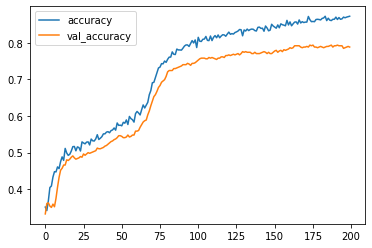

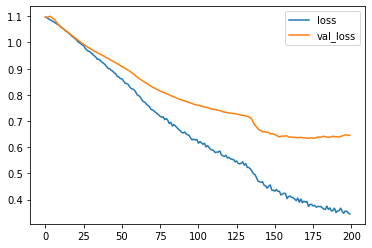

In [22]:
history = model.fit(train_imgs, train_df,batch_size=32,epochs=200,
                    steps_per_epoch=len(train_imgs)/32,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs, val_df))


pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

save model weight

In [23]:
model.save_weights('ocular_v7.h5')
model.save('ocular_model_v7.h5')